# ДЗ 2. CNN
### Таня Казакова

In [1]:
pip install torchvision 

In [2]:
!pip install torchmetrics

     |████████████████████████████████| 332 kB 12.6 MB/s 


In [5]:
pip install pymorphy2

     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 30.3 MB/s 


In [49]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer
import collections
from collections import Counter
import torch
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
from tqdm import tqdm
tqdm.pandas()
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
def lemmatizing(text):
    toks = word_tokenize(text)
    words = [w.lower() for w in toks if w.isalpha()]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return lemmas

In [10]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

Это бывшая колаб тетрадка. Если хотите у себя перезапустить, надо поменять ссылки на корпусные файлы.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
colnames=['id', 'date', 'name', 'text', 'type', 'rep', 'rtw', 'fav', 'stcount', 'foll', 'frien', 'listcount']
posit = pd.read_csv('/content/drive/MyDrive/ВШЭ/Прог-е/python-personal/4 курс/positive.csv', sep=";", names=colnames)
negat = pd.read_csv('/content/drive/MyDrive/ВШЭ/Прог-е/python-personal/4 курс/negative.csv', sep=";", names=colnames)

In [13]:
posit['sent'] = 1
negat['sent'] = 0
twits = pd.concat([posit,negat],axis=0, ignore_index=True)
twits

,id,date,name,text,type,rep,rtw,fav,stcount,foll,frien,listcount,sent
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0,1
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2,1
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0,1
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0,1
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
226829,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,-1,0,0,0,1138,32,46,0,0
226830,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,-1,0,0,0,4822,38,32,0,0
226831,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",-1,0,0,1,165,13,16,0,0
226832,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",-1,0,1,0,2516,187,265,0,0


In [17]:
twits['words'] = twits['text'].progress_apply(lambda x: lemmatizing(x))
twits

100%|██████████| 226834/226834 [12:29<00:00, 302.77it/s]


,id,date,name,text,type,rep,rtw,fav,stcount,foll,frien,listcount,sent,words
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0,1,"[хоть, я, и, школотый, но, поверь, у, мы, то, ..."
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2,1,"[да, он, немного, похожий, на, он, но, мой, ма..."
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0,1,"[rt, katiacheh, ну, ты, идиотка, я, испугаться..."
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0,1,"[rt, кто, то, в, угол, сидеть, и, погибать, от..."
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1,1,"[вот, что, значит, страшилка, d, но, блин, пос..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226829,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,-1,0,0,0,1138,32,46,0,0,"[но, не, каждый, хотеть, что, то, исправлять, ..."
226830,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,-1,0,0,0,4822,38,32,0,0,"[скучать, так, только, taaannyaaa, вправлять, ..."
226831,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",-1,0,0,1,165,13,16,0,0,"[вот, и, в, школа, в, говно, это, идти, уже, н..."
226832,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",-1,0,1,0,2516,187,265,0,0,"[rt, lisaberoud, тауриэль, не, грусть]"


In [18]:
# Делаем word2id и id2word

vocab = Counter()
for twit in twits['words']:
    for word in twit:
        vocab[word] +=1
print('Всего уникальных символов:', len(vocab))
filtered_vocab = set()
for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)
print('Уникальных символов, втретившихся больше 2 раз:', len(filtered_vocab))
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}

Всего уникальных символов: 141526
Уникальных символов, втретившихся больше 2 раз: 35573


## Первая модель

In [19]:
class TwitDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['words'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = dataset['sent'].values
        self.device = DEVICE


    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = list(self.dataset[index])
        ids = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_ids, y

In [20]:
data = twits[['words', 'sent']]
data

,words,sent
0,"[хоть, я, и, школотый, но, поверь, у, мы, то, ...",1
1,"[да, он, немного, похожий, на, он, но, мой, ма...",1
2,"[rt, katiacheh, ну, ты, идиотка, я, испугаться...",1
3,"[rt, кто, то, в, угол, сидеть, и, погибать, от...",1
4,"[вот, что, значит, страшилка, d, но, блин, пос...",1
...,...,...
226829,"[но, не, каждый, хотеть, что, то, исправлять, ...",0
226830,"[скучать, так, только, taaannyaaa, вправлять, ...",0
226831,"[вот, и, в, школа, в, говно, это, идти, уже, н...",0
226832,"[rt, lisaberoud, тауриэль, не, грусть]",0


In [21]:
train_data, val_data = train_test_split(data, test_size=0.2)

In [22]:
train_dataset = TwitDataset(train_data, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn,
                            sampler=train_sampler, batch_size=1024)

In [23]:
#train_data['sent'].values
batch = next(iter(train_iterator))
# batch[0].shape
# [id2word[int(i)] for i in batch[0][0]]
# batch[1]

In [24]:
val_dataset = TwitDataset(val_data, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn,
                          sampler=val_sampler, batch_size=1024)

In [25]:
val_batch = next(iter(val_iterator))
val_batch[0].shape

torch.Size([1024, 27])

In [26]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bigrams2 = nn.Conv1d(in_channels=180, out_channels=100, kernel_size=2, padding='same')
        self.hidden = nn.Linear(in_features=100, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.bigrams(embedded)
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.trigrams(embedded)
        
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        cnn_bigrams = self.bigrams2(concat)
        pooling1 = cnn_bigrams.max(2)[0] 
        logits = self.hidden(pooling1) 
        logits = self.out(logits)      
        return logits

Хорошо бы ReLU делать, но в условии указано не было.

In [39]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/(i+1)}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [41]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)  # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/(i+1)}, Val f1: {epoch_metric/(i+1)}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) # возвращаем среднее значение по всей выборке

In [42]:
model = CNN(len(word2id), 186)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [43]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(25):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.633270822252546
Train loss: 0.6111162092004504
Train loss: 0.597837766011556
Train loss: 0.5880684162889208
Train loss: 0.5803372754369464

Evaluating on train...
Val loss: 0.5294849344662258, Val f1: 0.7184273600578308
Val loss: 0.5307746231555939, Val f1: 0.7152470946311951
Val loss: 0.530101268064408, Val f1: 0.7168515920639038
Val loss: 0.5295495480298996, Val f1: 0.7177861332893372
Val loss: 0.5295645461763654, Val f1: 0.7176051139831543

Evaluating on test...
Val loss: 0.538373225265079, Val f1: 0.7058613896369934
Val loss: 0.5405049059126112, Val f1: 0.7014437317848206
Val loss: 0.5432412447752776, Val f1: 0.6990364789962769
Val loss: 0.5435484151045481, Val f1: 0.6997283697128296
Val loss: 0.5415586948394775, Val f1: 0.7021689414978027

starting Epoch 1
Training...
Train loss: 0.5280010376657759
Train loss: 0.5251829313380377
Train loss: 0.5215633389495667
Train loss: 0.5175592863133975
Train loss: 0.5142067858151027

Evaluating on tr

Модель переобучилась. Можно было и гораздо меньше эпох сделать. Минимальный valscore на тесте 0,48... на 5й эпохе  Теперь попробуем исправить и улучшить. Добавим nn.MaxPool1d, nn.ReLU, nn.Dropout.

## 1.2 модель

In [46]:
# CNN (почти из семинара)
class CNN(nn.Module):
   
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [47]:
model = CNN(len(word2id), 186)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [48]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(40):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.684097603389195
Train loss: 0.647581091097423
Train loss: 0.6288207565035139
Train loss: 0.6161215041364942
Train loss: 0.6071362257003784

Evaluating on train...
Val loss: 0.5686890244483948, Val f1: 0.7270284295082092
Val loss: 0.5693522427763258, Val f1: 0.7291648387908936
Val loss: 0.5693715243112474, Val f1: 0.7295404672622681
Val loss: 0.5689700075558254, Val f1: 0.7299821376800537
Val loss: 0.569250237260546, Val f1: 0.729559600353241

Evaluating on test...
Val loss: 0.5718412266837226, Val f1: 0.7296108603477478
Val loss: 0.5736293296019236, Val f1: 0.7267590761184692
Val loss: 0.5755414388797901, Val f1: 0.7253339886665344
Val loss: 0.5749556471904119, Val f1: 0.7247162461280823
Val loss: 0.57382140689426, Val f1: 0.725925862789154

starting Epoch 1
Training...
Train loss: 0.5567501391683306
Train loss: 0.5534912850175585
Train loss: 0.5514048003015064
Train loss: 0.5471885638577597
Train loss: 0.5440775282042367

Evaluating on train

Тоже переобучилась, но теперь минимальный val score 0,46... на 12 эпохе. Допустим, я на 13й эпохе остановаилась (можно не перезапускать...) Модель улучшилась.

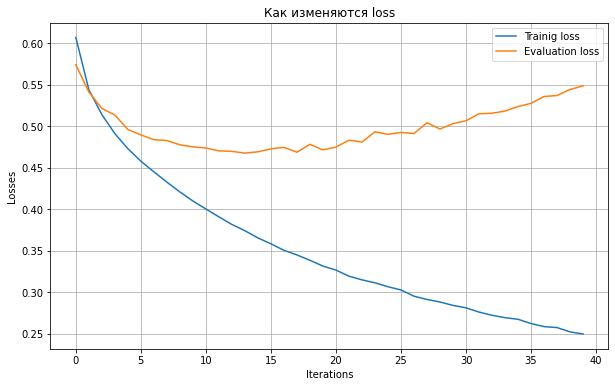

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.title('Как изменяется loss')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.grid()
ax.plot(losses, label='Trainig loss')
ax.plot(losses_eval, label='Evaluation loss')
ax.legend()
plt.show()

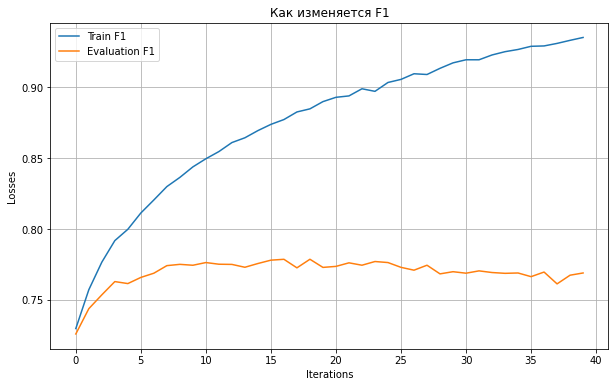

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.title('Как изменяется F1')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.grid()
ax.plot(f1s, label='Train F1')
ax.plot(f1s_eval, label='Evaluation F1')
ax.legend()
plt.show()

Как сильно улучшить: работать не только со словами, но и с символами, больше внимания уделять пунктуации, из которой состоят смайлики, которые указывают на настроение текста. См. вторую модель.

## Вторая модель

In [56]:
# Делаем symbol2id и id2symbol

vocab_s = Counter()
for text in twits['text']:
    vocab_s.update(list(text))
print('всего уникальных символов:', len(vocab_s))
filtered_vocab_s = set()

for symbol in vocab_s:
    if vocab_s[symbol] > 5:
        filtered_vocab_s.add(symbol)
print('уникальных символов, втретившихся больше 5 раз:', len(filtered_vocab_s))
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
symbol2id = {'PAD':0}

for symbol in filtered_vocab_s:
    symbol2id[symbol] = len(symbol2id)
#обратный словарь для того, чтобы раскодировать последовательность
id2symbol = {i:symbol for symbol, i in symbol2id.items()}

всего уникальных символов: 456
уникальных символов, втретившихся больше 5 раз: 234


In [57]:
twits['symbols'] = twits['text'].progress_apply(lambda x: list(x))
twits

100%|██████████| 226834/226834 [00:02<00:00, 77599.37it/s]


,id,date,name,text,type,rep,rtw,fav,stcount,foll,frien,listcount,sent,words,symbols
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0,1,"[хоть, я, и, школотый, но, поверь, у, мы, то, ...","[@, f, i, r, s, t, _, t, i, m, e, e, , х, о, ..."
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2,1,"[да, он, немного, похожий, на, он, но, мой, ма...","[Д, а, ,, , в, с, е, -, т, а, к, и, , о, н, ..."
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0,1,"[rt, katiacheh, ну, ты, идиотка, я, испугаться...","[R, T, , @, K, a, t, i, a, C, h, e, h, :, , ..."
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0,1,"[rt, кто, то, в, угол, сидеть, и, погибать, от...","[R, T, , @, d, i, g, g, e, r, 2, 9, 1, 2, :, ..."
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1,1,"[вот, что, значит, страшилка, d, но, блин, пос...","[@, i, r, i, n, a, _, d, y, s, h, k, a, n, t, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226829,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,-1,0,0,0,1138,32,46,0,0,"[но, не, каждый, хотеть, что, то, исправлять, ...","[Н, о, , н, е, , к, а, ж, д, ы, й, , х, о, ..."
226830,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,-1,0,0,0,4822,38,32,0,0,"[скучать, так, только, taaannyaaa, вправлять, ...","[с, к, у, ч, а, ю, , т, а, к, , :, -, (, , ..."
226831,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",-1,0,0,1,165,13,16,0,0,"[вот, и, в, школа, в, говно, это, идти, уже, н...","[В, о, т, , и, , в, , ш, к, о, л, у, ,, , ..."
226832,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",-1,0,1,0,2516,187,265,0,0,"[rt, lisaberoud, тауриэль, не, грусть]","[R, T, , @, _, T, h, e, m, _, _, :, , @, L, ..."


In [58]:
data2 = twits[['words', 'symbols', 'sent']]
data2

,words,symbols,sent
0,"[хоть, я, и, школотый, но, поверь, у, мы, то, ...","[@, f, i, r, s, t, _, t, i, m, e, e, , х, о, ...",1
1,"[да, он, немного, похожий, на, он, но, мой, ма...","[Д, а, ,, , в, с, е, -, т, а, к, и, , о, н, ...",1
2,"[rt, katiacheh, ну, ты, идиотка, я, испугаться...","[R, T, , @, K, a, t, i, a, C, h, e, h, :, , ...",1
3,"[rt, кто, то, в, угол, сидеть, и, погибать, от...","[R, T, , @, d, i, g, g, e, r, 2, 9, 1, 2, :, ...",1
4,"[вот, что, значит, страшилка, d, но, блин, пос...","[@, i, r, i, n, a, _, d, y, s, h, k, a, n, t, ...",1
...,...,...,...
226829,"[но, не, каждый, хотеть, что, то, исправлять, ...","[Н, о, , н, е, , к, а, ж, д, ы, й, , х, о, ...",0
226830,"[скучать, так, только, taaannyaaa, вправлять, ...","[с, к, у, ч, а, ю, , т, а, к, , :, -, (, , ...",0
226831,"[вот, и, в, школа, в, говно, это, идти, уже, н...","[В, о, т, , и, , в, , ш, к, о, л, у, ,, , ...",0
226832,"[rt, lisaberoud, тауриэль, не, грусть]","[R, T, , @, _, T, h, e, m, _, _, :, , @, L, ...",0


In [59]:
class TwitDataset2(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset_w = dataset['words'].values
        self.word2id = word2id
        self.dataset_s = dataset['symbols'].values
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = dataset['sent'].values
        self.device = DEVICE


    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = list(self.dataset_w[index])
        symbols = list(self.dataset_s[index])
        ids_w = torch.LongTensor([self.word2id[word] for word in words if word in self.word2id])
        ids_s = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        y = [self.target[index]]
        return ids_w, ids_s, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids_w, ids_s, y = list(zip(*batch))
        padded_ids_w = pad_sequence(ids_w, batch_first=True).to(self.device)
        padded_ids_s = pad_sequence(ids_s, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        
        return padded_ids_w, padded_ids_s, y

In [60]:
train_data2, val_data2 = train_test_split(data2, test_size=0.2)
train_dataset2 = TwitDataset2(train_data2, word2id, symbol2id, DEVICE)
train_sampler2 = RandomSampler(train_dataset2)
train_iterator2 = DataLoader(train_dataset2, collate_fn = train_dataset2.collate_fn,
                            sampler=train_sampler2, batch_size=1024)
#train_data['sent'].values
batch = next(iter(train_iterator2))
# batch[0].shape
# [id2word[int(i)] for i in batch[0][0]]
# batch[1]
val_dataset2 = TwitDataset2(val_data2, word2id, symbol2id, DEVICE)
val_sampler2 = SequentialSampler(val_dataset2)
val_iterator2 = DataLoader(val_dataset2, collate_fn = val_dataset2.collate_fn,
                          sampler=val_sampler2, batch_size=1024)
val_batch = next(iter(val_iterator2))
#val_batch[0].shape

In [61]:
class CNN_2(nn.Module):

    def __init__(self, vocab_size_w, embedding_dim_w, vocab_size_s, embedding_dim_s):
        super().__init__()
        self.embedding_w = nn.Embedding(vocab_size_w, embedding_dim_w)
        self.embedding_s = nn.Embedding(vocab_size_s, embedding_dim_s)
        self.hid_for_senten = nn.Linear(in_features=embedding_dim_w, out_features=embedding_dim_w//2)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim_s, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim_s, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180+embedding_dim_w//2, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, padded_ids_w, padded_ids_s):
        words = padded_ids_w
        symbols = padded_ids_s
        
        #batch_size x seq_len
        embedded_w = self.embedding_w(words)
        embedded_sentence = torch.mean(embedded_w, dim=1)
        vec_X = self.hid_for_senten(embedded_sentence)
        
        #batch_size x seq_len
        embedded_s = self.embedding_s(symbols)
        
        #batch_size x seq_len x embedding_dim
        embedded_s = embedded_s.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.bigrams(embedded_s))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.trigrams(embedded_s))))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2, vec_X), 1)
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [70]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем,
                   # что сейчас надо будет хранить градиенты у всех весов

    for i, (words, symbols, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(words, symbols)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/(i+1)}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [71]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (words, symbols, ys) in enumerate(iterator):   
            preds = model(words, symbols)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
                print(f'Val loss: {epoch_loss/(i+1)}, Val f1: {epoch_metric/(i+1)}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)
                                   # возвращаем среднее значение по всей выборке

In [72]:
model = CNN_2(len(word2id), 186, len(symbol2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [68]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(50):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator2, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator2, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator2, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.65715685571943
Train loss: 0.6202949575015477
Train loss: 0.5789406251339685
Train loss: 0.5333271335278239
Train loss: 0.4873780977725983

Evaluating on train...
Val loss: 0.3116850427218846, Val f1: 0.9082210063934326
Val loss: 0.31212810235364097, Val f1: 0.9070793986320496
Val loss: 0.31253594358762105, Val f1: 0.9062703251838684
Val loss: 0.31335519062621253, Val f1: 0.90558260679245
Val loss: 0.31341134326798575, Val f1: 0.9057555794715881

Evaluating on test...
Val loss: 0.3129340178436703, Val f1: 0.9067867398262024
Val loss: 0.31431927780310315, Val f1: 0.9064907431602478
Val loss: 0.3140040625024725, Val f1: 0.9054238200187683
Val loss: 0.3139054874579112, Val f1: 0.9057860970497131
Val loss: 0.31367385851012336, Val f1: 0.9070649147033691

starting Epoch 1
Training...
Train loss: 0.2237735458782741
Train loss: 0.19489643062864032
Train loss: 0.17123624568893797
Train loss: 0.15253119207918645
Train loss: 0.13709900592054639

Evalua

Улучшим, уберём дропаут. За меньшее количество эпох результат получится лучше.

## 2.2 модель

In [69]:
class CNN_2(nn.Module):
    
    def __init__(self, vocab_size_w, embedding_dim_w, vocab_size_s, embedding_dim_s):
        super().__init__()
        self.embedding_w = nn.Embedding(vocab_size_w, embedding_dim_w)
        self.embedding_s = nn.Embedding(vocab_size_s, embedding_dim_s)
        self.hid_for_senten = nn.Linear(in_features=embedding_dim_w, out_features=embedding_dim_w//2)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim_s, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim_s, out_channels=80, kernel_size=3, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180+embedding_dim_w//2, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, padded_ids_w, padded_ids_s):
        words = padded_ids_w
        symbols = padded_ids_s
        
        #batch_size x seq_len
        embedded_w = self.embedding_w(words)
        embedded_sentence = torch.mean(embedded_w, dim=1)
        vec_X = self.hid_for_senten(embedded_sentence)
        
        #batch_size x seq_len
        embedded_s = self.embedding_s(symbols)
        
        #batch_size x seq_len x embedding_dim
        embedded_s = embedded_s.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.pooling(self.relu(self.bigrams(embedded_s)))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.pooling(self.relu(self.trigrams(embedded_s)))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2, vec_X), 1)
        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [66]:
model = CNN_2(len(word2id), 186, len(symbol2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [74]:
losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(30):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator2, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator2, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator2, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.6432758058820452
Train loss: 0.607628516639982
Train loss: 0.5574081457796551
Train loss: 0.4997933302606855
Train loss: 0.4437719122001103

Evaluating on train...
Val loss: 0.17773547513144358, Val f1: 0.9639342427253723
Val loss: 0.17588233245270593, Val f1: 0.9646584987640381
Val loss: 0.17557115157445272, Val f1: 0.9647602438926697
Val loss: 0.17531021301235472, Val f1: 0.9652224779129028
Val loss: 0.17499568598611015, Val f1: 0.9654300212860107

Evaluating on test...
Val loss: 0.17225799295637342, Val f1: 0.9684064984321594
Val loss: 0.17355242123206457, Val f1: 0.9679866433143616
Val loss: 0.1741201270509649, Val f1: 0.9664027690887451
Val loss: 0.17567125086983046, Val f1: 0.9653493165969849
Val loss: 0.17623135613070595, Val f1: 0.9653328061103821

starting Epoch 1
Training...
Train loss: 0.15376799958092827
Train loss: 0.1365033404103347
Train loss: 0.12360749883311135
Train loss: 0.1143392311675208
Train loss: 0.10691445380449295

E

Класс...

Лучше модель справляется с твитами, в которых есть смайлики. :) :D XD и т.д... А вот без смайликов чуть сложнее. Но всё равно хорошо работает.